# Yemen NTL Trends

1. Pull and process NTL imagery for all of Yemen, from January 2021 through latest available. 
2. Create 2 line charts, tracking monthly percent change (or other normalized index) of NTL by admin-level 1 (governorate), with markers for the period from 4/2022 to 10/2022, and another chart, with just two lines, for aggregated North (Houthis) and South (IRG) admin-1s. 
3. Prepare a table with the raw data, that the team can use for further analysis and indexing. 

## Authenticate Earth Engine Account

In [1]:
import ee

This only needs to be run once, will prompt a browser to log in to auhtorize access to your Earth Engine account. Need to copy token and paste in the cell.

In [3]:
ee.Authenticate()


Successfully saved authorization token.


### Import other libraries

In [4]:
import os, sys
from os.path import join, expanduser
from glob import glob
from gadm import GADMDownloader

import geopandas as gpd
import pandas as pd
from gee_zonal import ZonalStats, gee_helpers

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format, comma_format
import plotnine
import folium as flm

## Download Admin Boundaries

100%|██████████| 5.44M/5.44M [00:01<00:00, 4.33MB/s]


<Axes: >

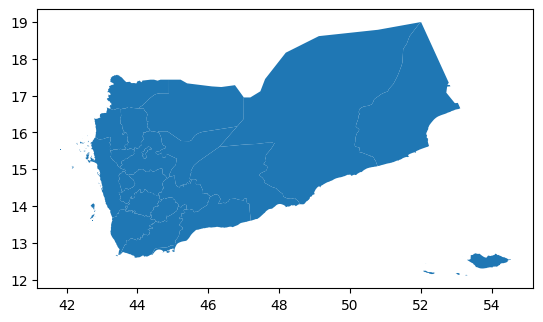

In [5]:
downloader = GADMDownloader(version="4.0")
country_name = "Yemen"
ad_level = 1
gadm1 = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)
gadm1.plot()

## NTL Data Cleaning

In [6]:
start = "2018-01-01"
end = "2023-05-01"

### Check for cloud cover

This step uses the cloud-free-coverage band raible in the NTL data to examine the quality of the data, and identify if there are months with no valid daily NTL observations to use in the monthly composite.

Zonal statistics are extracted from GEE datasets using the [GEE Zonal](https://worldbank.github.io/GEE_Zonal/) package.

In [7]:
coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").select('cf_cvg').filterDate(start, end)

# get coverage with valid observations greater than 0
def getGT0(image): 
    return image.gt(0).clip(aoi).set('system:time_start', image.get('system:time_start'))

# get total number of observations (coverage greater or equal to 0)
def getGTE0(image):
    return image.gte(0).clip(aoi).set('system:time_start', image.get('system:time_start'))

aoi = gee_helpers.gpd_to_gee(gadm1)

coverage_gt0 = coverage.map(getGT0)
coverage_gte0 = coverage.map(getGTE0)

zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gt0
)
res = zs.runZonalStats()
df_gt0 = res.copy()

zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gte0
)
res = zs.runZonalStats()
df_gte0 = res.copy()

# calculate percentage of valid observations
cols_cf = ['cf' in col for col in df_gt0.columns]
cols = list(~pd.Series(cols_cf))
df_pct = df_gt0.iloc[:, cols].join(df_gt0.loc[:, cols_cf].divide(df_gte0.loc[:, cols_cf]))
def rename_func(col):
    if "cf_cvg" in col:
        p = col.split("_")
        new_name = "pct"+"__"+p[0]
        return(new_name)
    else:
        return col
df_pct.rename(rename_func, axis=1, inplace=True)
df_pct_re = pd.wide_to_long(
    df_pct,
    stubnames = ['pct'],
    i = 'NAME_1',
    j = 'date',
    sep = "__"
)
df_pct_re.reset_index(inplace=True)
df_pct_re.loc[:,"ym"] = pd.to_datetime(df_pct_re.date, format="%Y%m%d")

In [8]:
plotnine.options.figure_size = (12, 12)

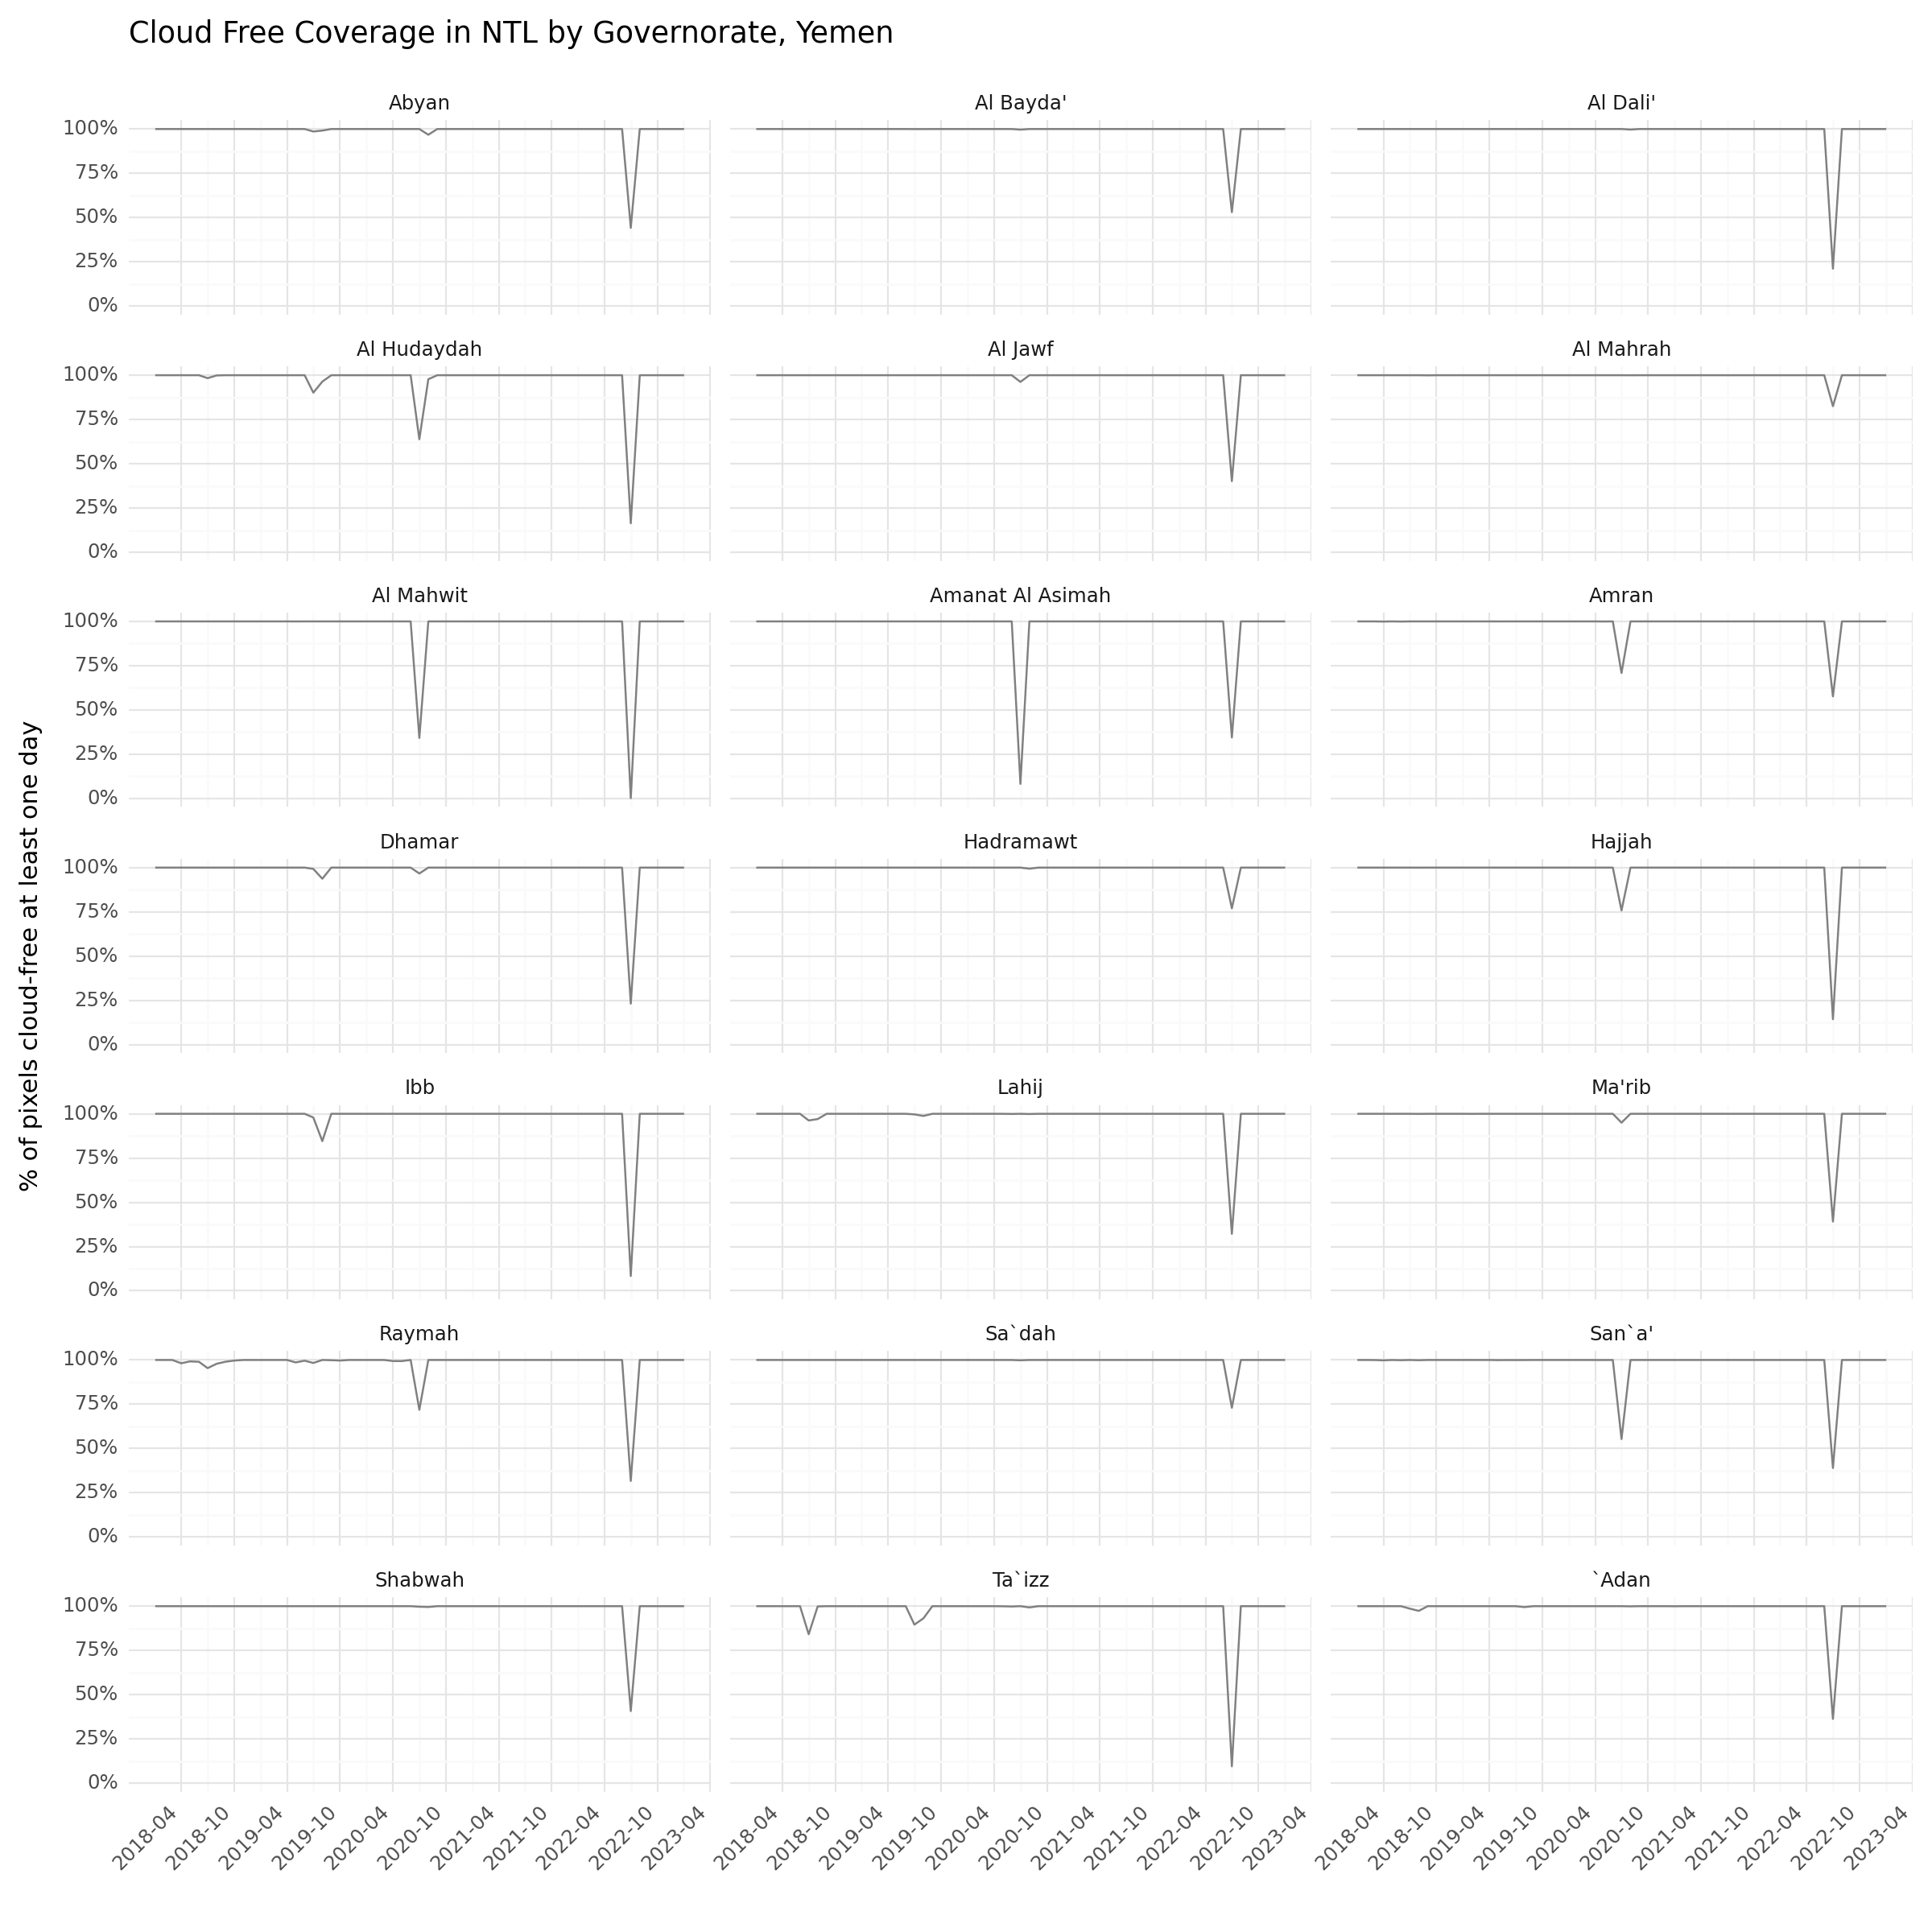

<Figure Size: (1200 x 1200)>

In [9]:
plot = (
ggplot(df_pct_re, aes(x="ym", y="pct", group="NAME_1")) #
    + geom_line(alpha=1, color="gray")
    + labs(
        x="", y="% of pixels cloud-free at least one day", title="Cloud Free Coverage in NTL by Governorate, Yemen",
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('6 months'), labels=date_format('%Y-%m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
plot

### Interpolate pixels with missing data due to clouds

The following function applies a smoothing algorithm to the data using a moving-window (3 months before and after) linear regression pixel-by-pixel. For pixels with no valid observations, it replaces the missing data with the interpotated values.

In [10]:
def smoothenViirs(collection, window_size):

    def prepareImage(img):
        rad = img.select('avg_rad')
        cf_cvg = img.select('cf_cvg')
        cf_eq0 = cf_cvg.gt(0)
        img_masked = rad.mask(cf_eq0)

        date = img.date()
        # add a time variable
        months = date.difference(ee.Date('1970-01-01'), 'month')
        return img_masked.addBands(ee.Image(months).rename('time')).float()

    def smoother(t):
        # helper function to apply linear regression equation
        def applyFit(img):
            return img.select('time').multiply(fit.select('scale')) \
                    .add(fit.select('offset')) \
                    .set('system:time_start',img.get('system:time_start')) \
                    .rename('avg_rad')
        
        t = ee.Date(t)
        
        window = data.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month'))
        
        fit = window.select(['time','avg_rad']) \
            .reduce(ee.Reducer.linearFit())
        
        return window.map(applyFit).toList(10)
    
    # function to reduce time stacked linear regression results
    # requires that a variable 'fitIC' exists from the smoother function
    def reduceFits(t):
        t = ee.Date(t)
        return fitIC.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month')) \
                  .mean().set('system:time_start',t.millis()).rename('avg_rad')
    
    def replace(original):
        date = original.date()
        smoothed_sel = smoothed.filterDate(date, date.advance(1, 'day'))
        smooth = smoothed_sel.first()
        return smooth.where(original, original)
    
    data = collection \
        .map(prepareImage)
    
    # get unique dates
    dates = ee.List(data.aggregate_array('system:time_start'))
    
    fitIC = ee.ImageCollection(dates.map(smoother).flatten())
    
    smoothed = ee.ImageCollection(dates.map(reduceFits))
    
    collection_fill = data.select('avg_rad').map(replace)
    return collection_fill

In [11]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").select('avg_rad').filterDate(start, end) # VCMSLCFG
viirs_copy = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG").filterDate(start, end)
viirs_interpolated = smoothenViirs(viirs_copy, 3)

### Run zonal stats on NTL (both raw and gap-filled)

In [12]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = viirs
)
res = zs.runZonalStats()
df_ee = res.copy()

def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        if len(p)>1:
            new_name = "rad"+"__"+p[0]
            return(new_name)
        else:
            return col
    else:
        return col
df_ee.rename(rename_func, axis=1, inplace=True)
df_ee = pd.wide_to_long(
    df_ee,
    stubnames = ['rad'],
    i = 'NAME_1',
    j = 'date',
    sep = "__"
)
df_ee.reset_index(inplace=True)
df_ee.loc[:,"ym"] = pd.to_datetime(df_ee.date, format="%Y%m%d")

In [13]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = viirs_interpolated
)
res = zs.runZonalStats()
df_ee_int = res.copy()

def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        if len(p)>1:
            new_name = "rad"+"__"+p[0]
            return(new_name)
        else:
            return col
    else:
        return col
df_ee_int.rename(rename_func, axis=1, inplace=True)
df_ee_int = pd.wide_to_long(
    df_ee_int,
    stubnames = ['rad'],
    i = 'NAME_1',
    j = 'date',
    sep = "__"
)
df_ee_int.reset_index(inplace=True)
df_ee_int.loc[:,"ym"] = pd.to_datetime(df_ee_int.date, format="%Y%m%d")

### Merge both time series

In [14]:
df_ee_int.rename(columns={"rad":"rad_int"}, inplace=True)

In [15]:
df = df_ee.merge(df_ee_int[['NAME_1', 'ym', 'rad_int']], on=['NAME_1', 'ym'], how='left', validate='1:1')

In [16]:
df.loc[:, "month"] = df.ym.dt.month
df.loc[:, "year"] = df.ym.dt.year

In [30]:
onedrive_dir = r'C:\Users\WB514197\OneDrive - WBG\GOST_Deliverables\Yemen_NTL'
# data_dir = join(expanduser("~"), 'data')
# output_dir = join(expanduser("~"), 'output', 'yem')
output_dir = join(onedrive_dir, 'Data')


In [32]:
df.head()

,NAME_1,date,ID_0,TYPE_1,CC_1,HASC_1,NL_NAME_1,ENGTYPE_1,ISO_1,VARNAME_1,ID_1,COUNTRY,rad,ym,rad_int,month,year
0,`Adan,20180101,YEM,Muhafazah,24,YE.AD,عدن,Governorate,,Aden,YEM.1_1,Yemen,11760.768553,2018-01-01,11526.664663,1,2018
1,Abyan,20180101,YEM,Muhafazah,12,YE.AB,أبين,Governorate,,,YEM.2_1,Yemen,7814.861088,2018-01-01,7756.142594,1,2018
2,Al Bayda',20180101,YEM,Muhafazah,14,YE.BA,البيضاء,Governorate,,Albaidah|Al Baidha|Al-Baydha|Al Beida|Baidaa|A...,YEM.3_1,Yemen,3051.297134,2018-01-01,3075.272802,1,2018
3,Al Dali',20180101,YEM,Muhafazah,30,YE.DL,الضالع,Governorate,,Al Dhale'e,YEM.4_1,Yemen,1900.279527,2018-01-01,1902.250158,1,2018
4,Al Hudaydah,20180101,YEM,Muhafazah,18,YE.HU,الحديده,Governorate,,Al Hodeida|Al-Hodeidah|Al Hudaidah|Hodiedah|Hu...,YEM.5_1,Yemen,9720.596979,2018-01-01,9940.506484,1,2018


In [38]:
df.loc[:, df.columns!='rad'].to_csv(join(output_dir, 'adm1_viirs_raw_data.csv'), index=False)

### Plot NTL (raw and gap-filled)

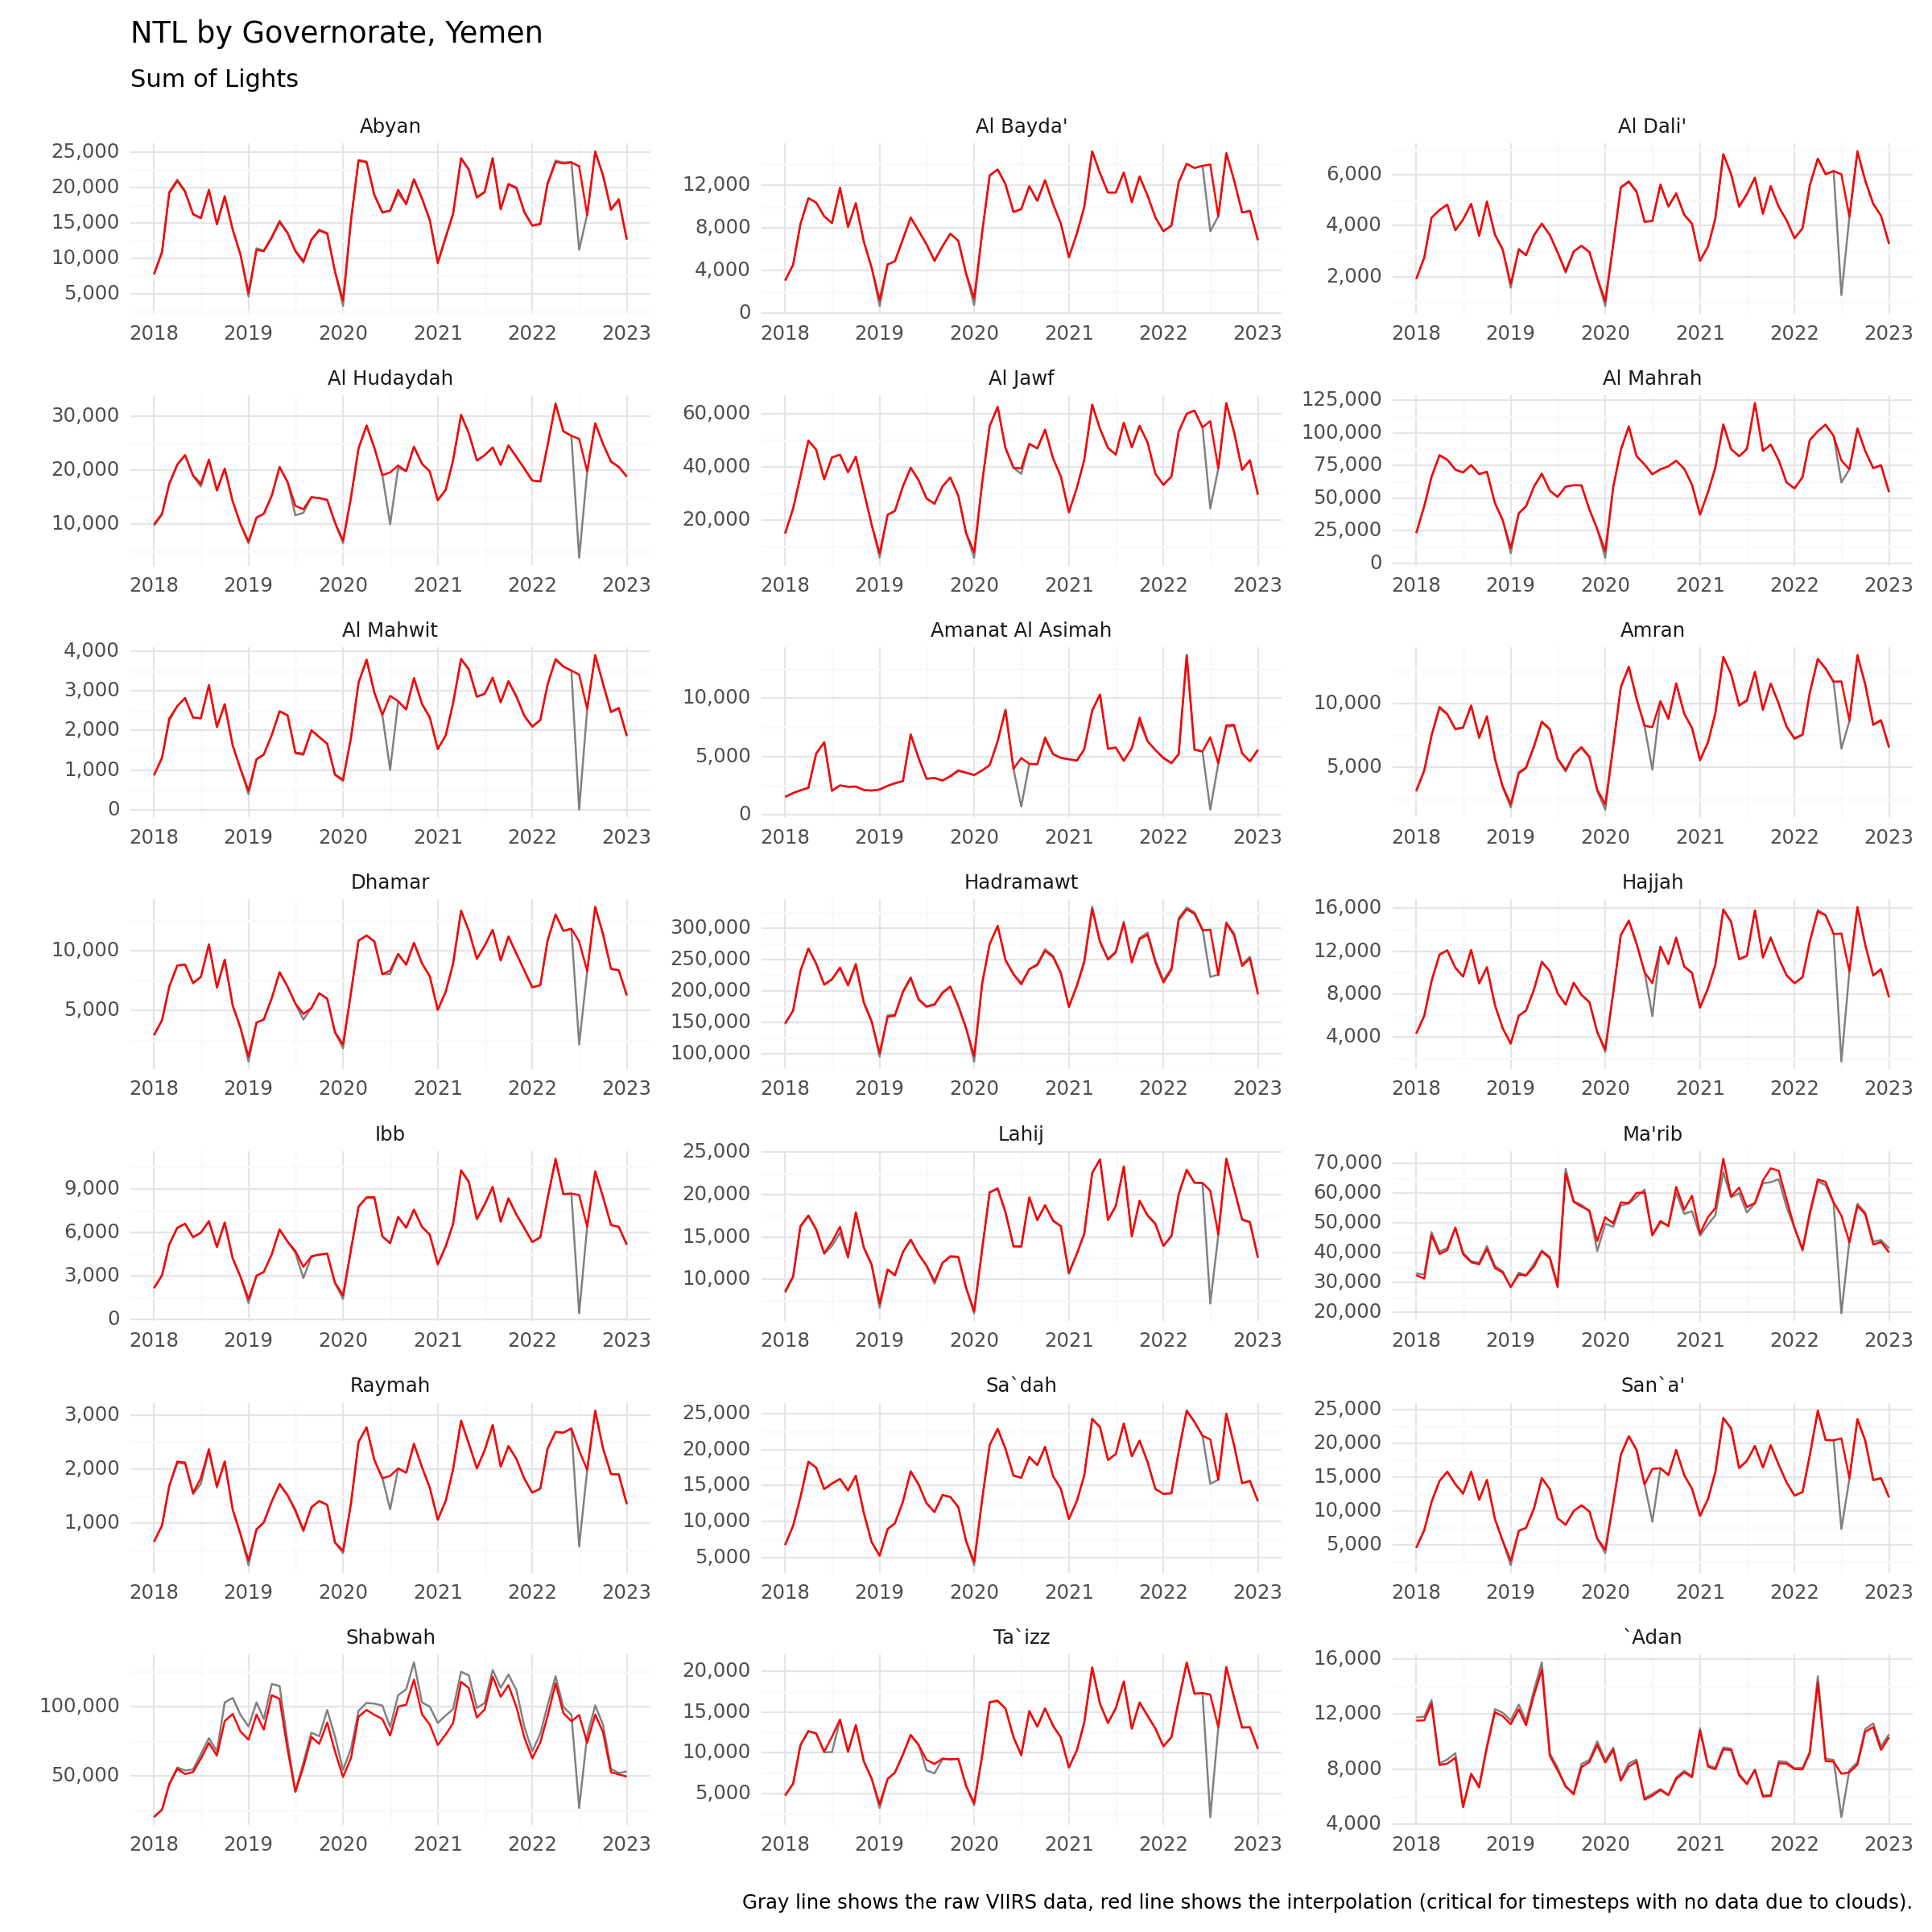

<Figure Size: (1200 x 1200)>

In [21]:
p4 = (
ggplot(df, aes(x="ym", y="rad", group="NAME_1")) #
    + geom_line(alpha=1, color="gray")
    + geom_line(aes(x="ym", y="rad_int", group="NAME_1"), color="red")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="Sum of Lights",
        caption="Gray line shows the raw VIIRS data, red line shows the trend with interpolated missing values (critical for timesteps with no data due to clouds)."
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y'))
    + scale_y_continuous(labels=comma_format())
    # + scale_y_continuous(labels=percent_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "free", ncol=3)
)
p4
# p4.save(filename=join(output_dir, 'adm1-lights-interpolation.jpeg'), dpi=300)

## NTL difference from baseline

### Calculate reference values

In [23]:
def calculate_ref(period):
    if period==2021:
        df_ref = df.loc[df.year==2021,:].copy()
    else:
        df_ref = df.loc[df.year<2022,:].copy()
    
    df_ref = df_ref.groupby(["NAME_1", "month"])[['rad', 'rad_int']].mean().reset_index()
    df_ref.rename(columns={"rad":"rad_ref", "rad_int":"rad_int_ref"}, inplace=True)

    df_filt = df.merge(df_ref, on=["NAME_1", "month"], how="left", validate="m:1")
    df_filt = df_filt.loc[df_filt.ym>="2022-01-01",:].copy()
    df_filt.loc[:, "rad_int_pct"] = df_filt.rad_int / df_filt.rad_int_ref
    df_filt.loc[:, "rad_int_pct_ch"] = df_filt.apply(lambda x: (x.rad_int-x.rad_int_ref) / (x.rad_int_ref), axis=1)
    df_filt.loc[:, "direction"] = ""
    df_filt.loc[df_filt.rad_int_pct_ch<0, "direction"] = "decrease"
    df_filt.loc[df_filt.rad_int_pct_ch>0, "direction"] = "increase"

    return df_filt

In [24]:
df_historical_baseline = calculate_ref('historical')
df_2021_baseline = calculate_ref(2021)

### Graphs

#### Pct. Change from baseline

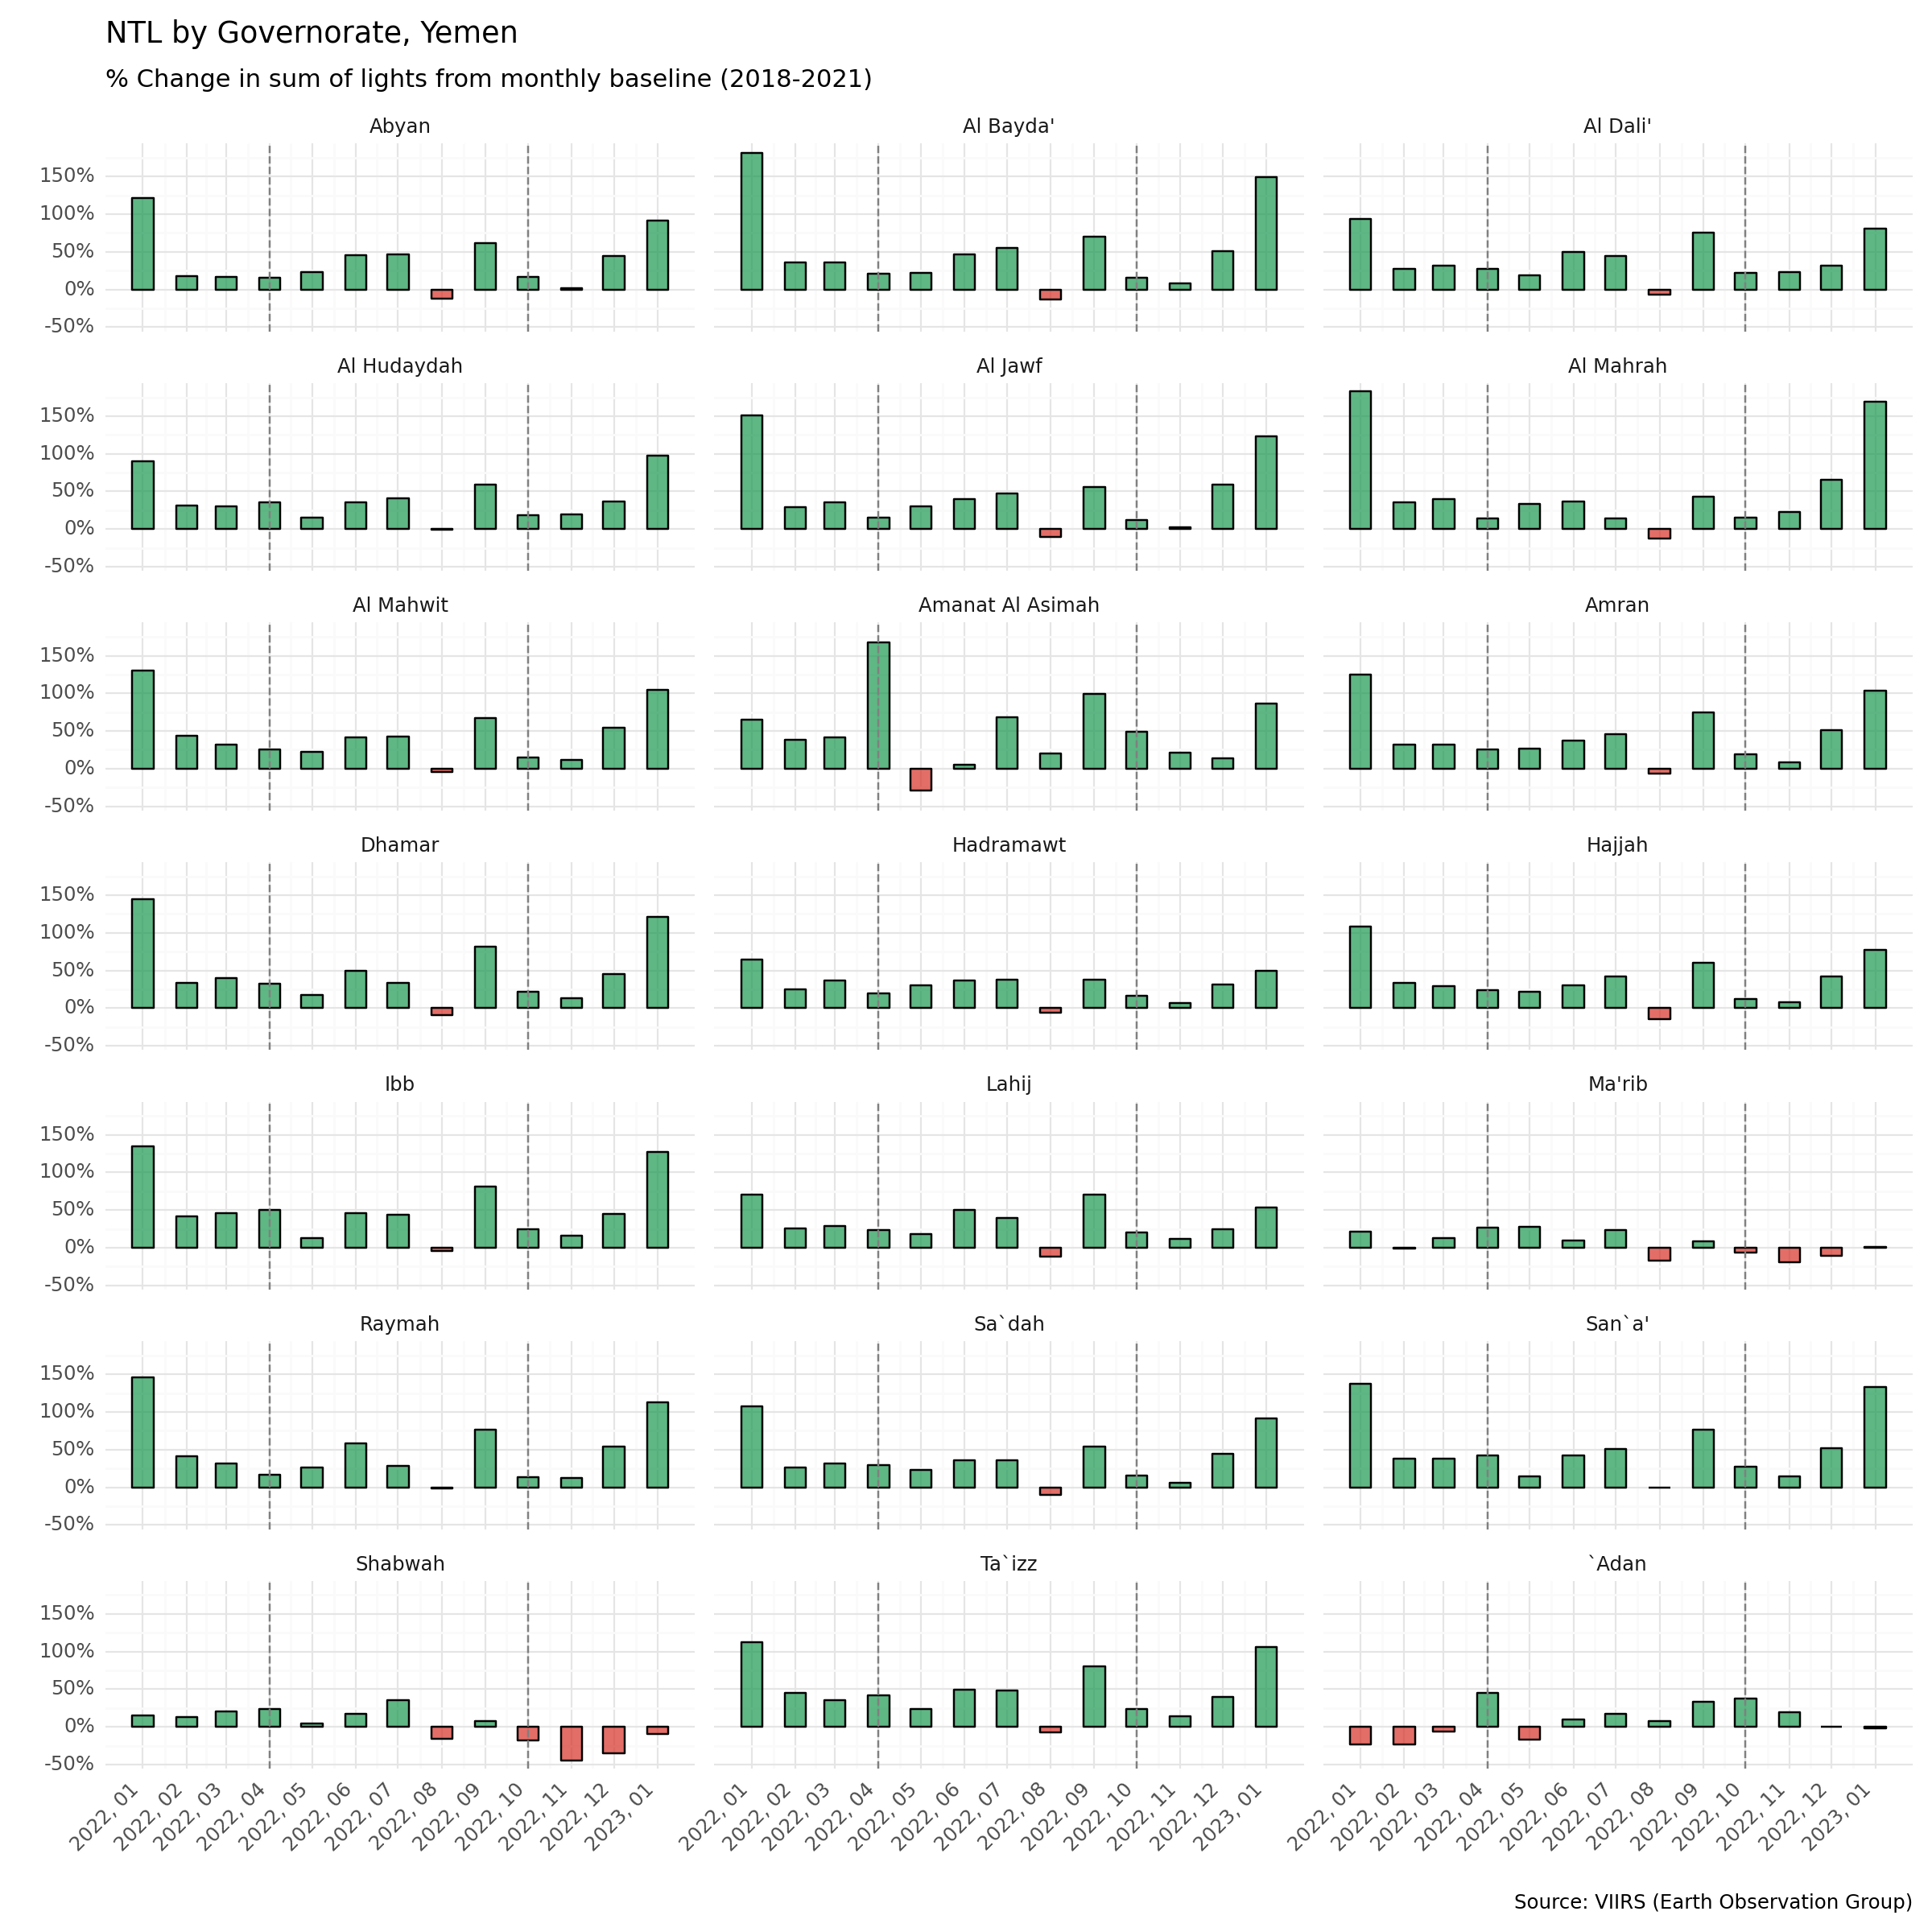

<Figure Size: (1200 x 1200)>

In [25]:
p1 = (
ggplot(df_historical_baseline, aes(x="ym", y="rad_int_pct_ch", group="NAME_1", fill="direction")) #
    + geom_col(alpha=0.7, color="black", width=15)
    # + geom_hline(yintercept=0)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from monthly baseline (2018-2021)",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='none')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(12, 12))
    + scale_fill_manual(values=['#d73027', '#1a9850'])
    # + scale_fill_brewer(type="div", palette="RdYlGn", name="Change in NTL", direction=1)
    # + scale_fill_distiller(type="div", palette="RdYlGn", name="Change in NTL", direction=1, limits=(-1, 1))
)
p1
# p1.save(filename=join(output_dir, 'adm1-pct-change-historical.jpeg'), dpi=300)

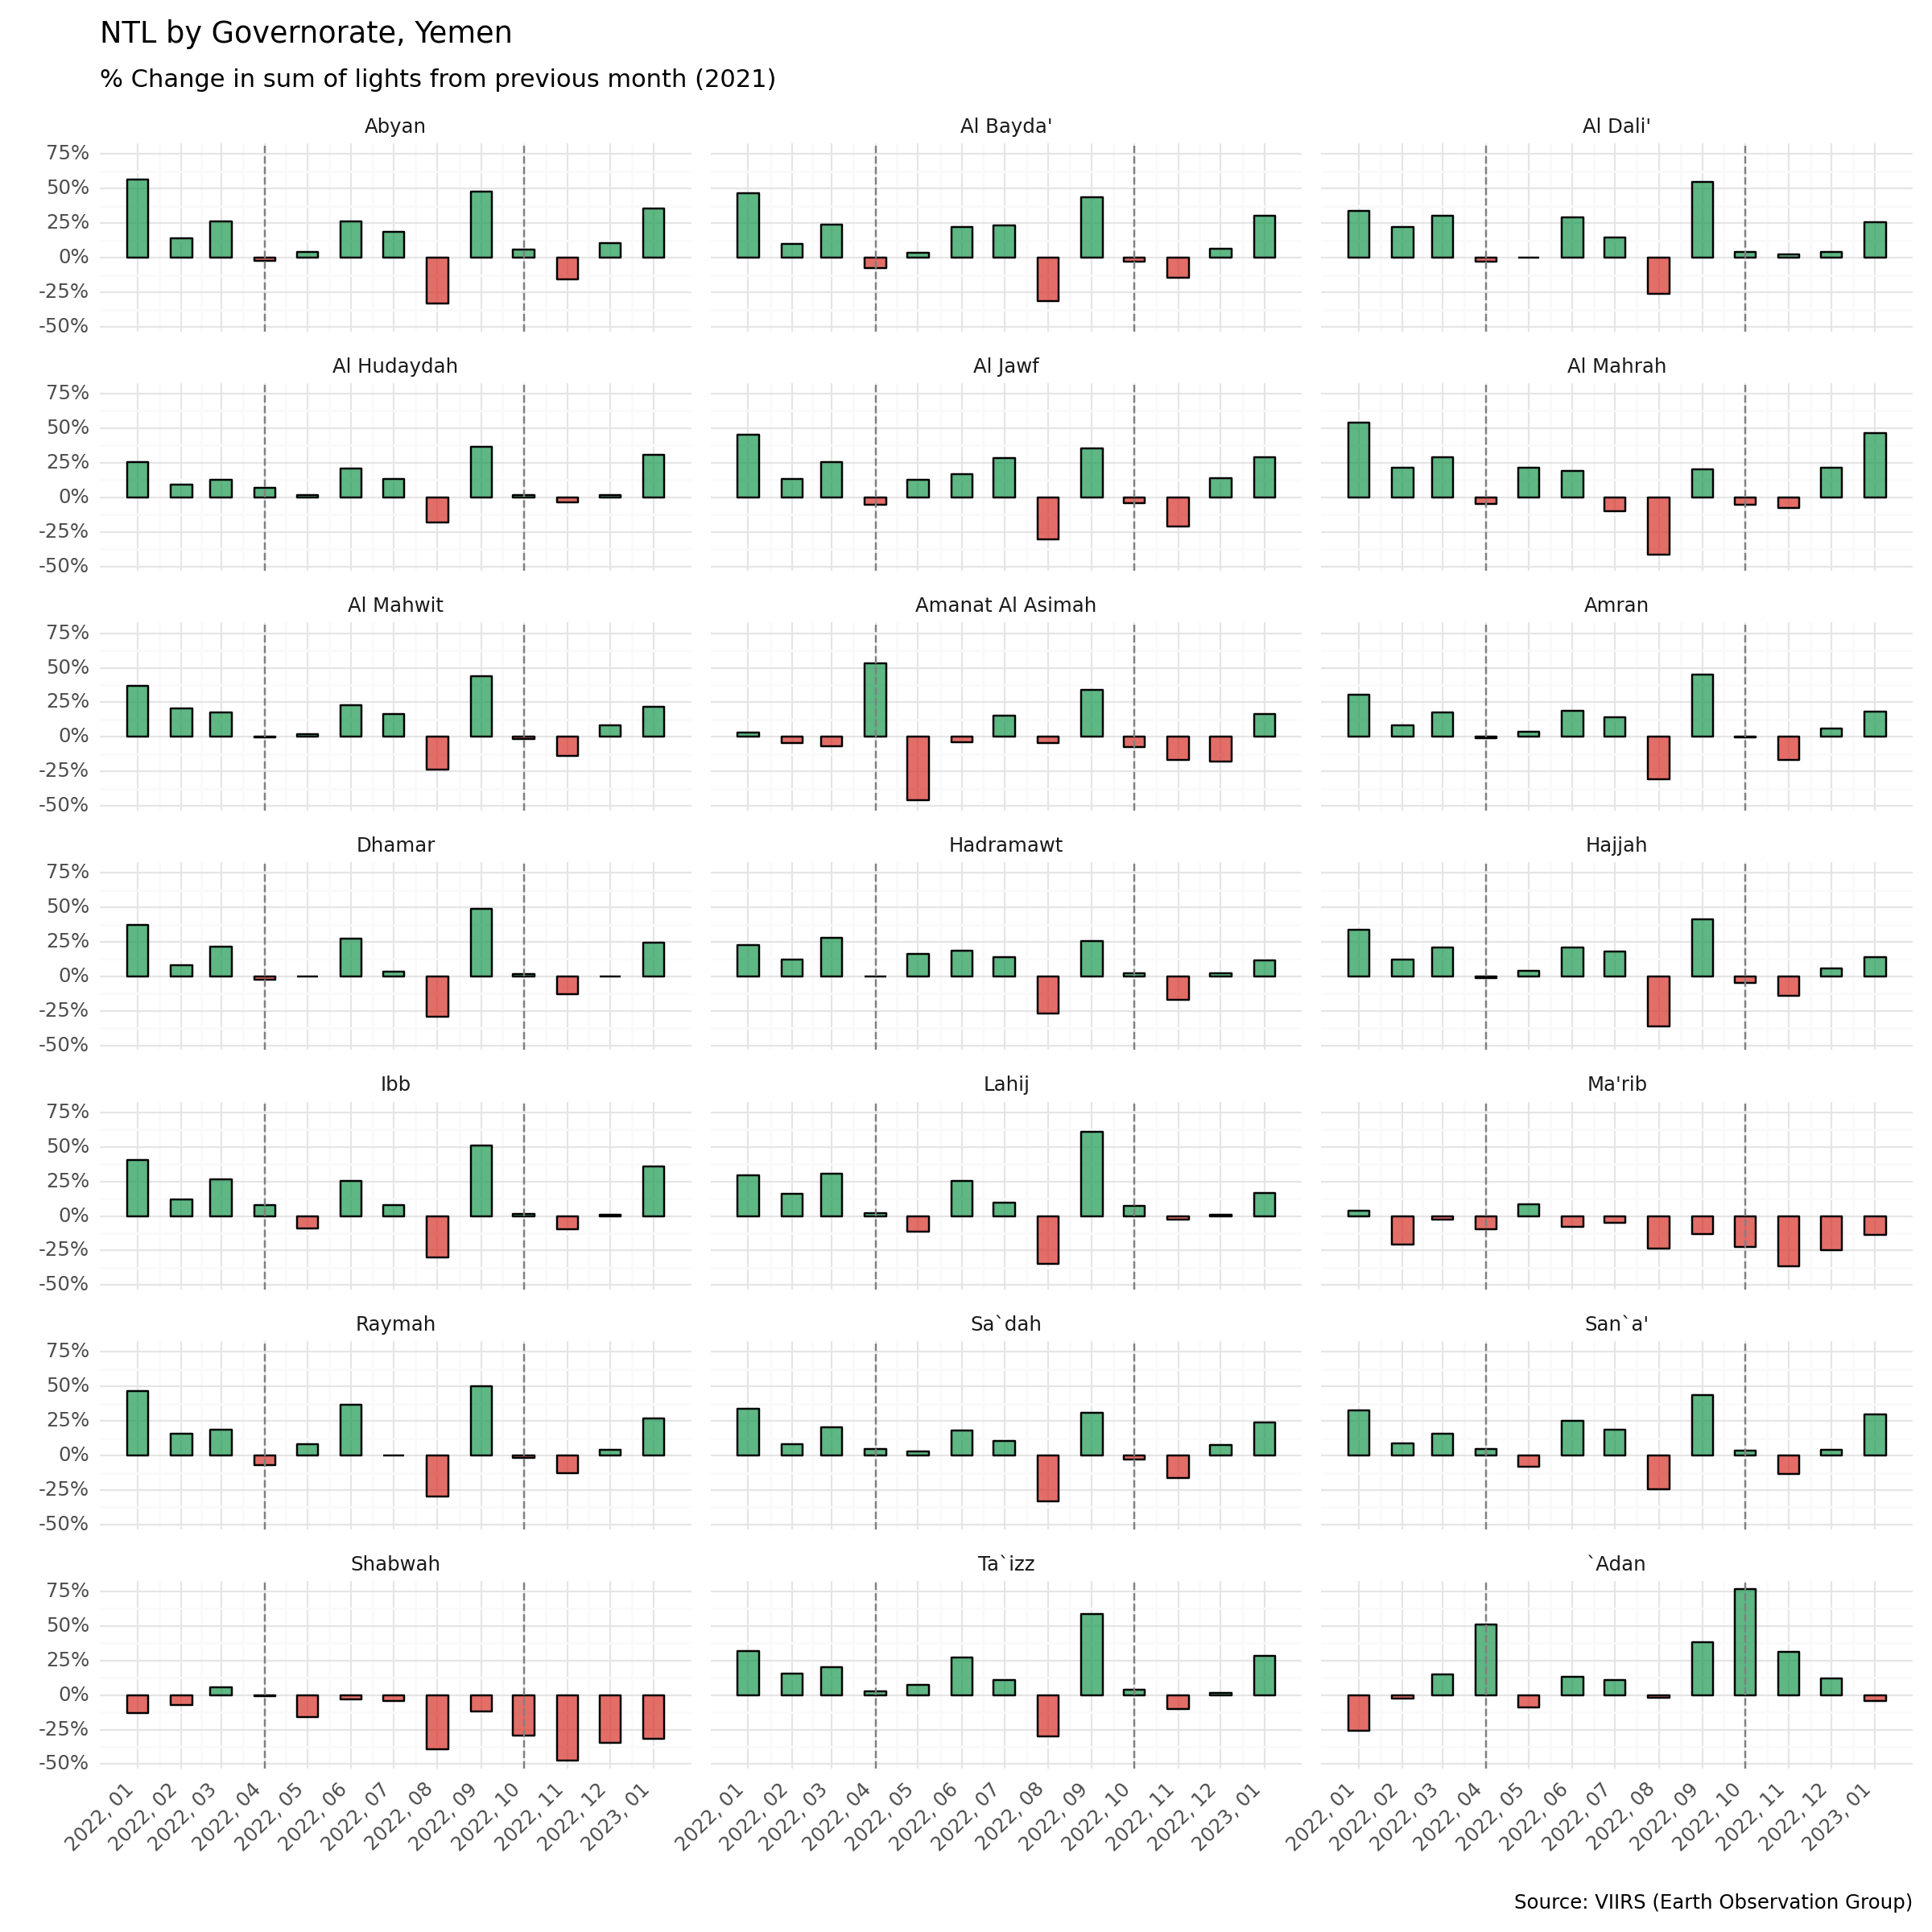

<Figure Size: (1200 x 1200)>

In [26]:
p2 = (
ggplot(df_2021_baseline, aes(x="ym", y="rad_int_pct_ch", group="NAME_1", fill="direction")) #
    + geom_col(alpha=0.7, color="black", width=15)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="% Change in sum of lights from previous month (2021)",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('1 month'), labels=date_format('%Y, %m'))
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position='none')
    + facet_wrap("~NAME_1", scales = "fixed", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + scale_fill_manual(values=['#d73027', '#1a9850'])
    # + scale_fill_brewer(type="div", palette="RdYlGn", name="Change in NTL", direction=1)
    # + scale_fill_distiller(type="div", palette="RdYlGn", name="Change in NTL", direction=1, limits=(-1, 1))
)
p2
# p2.save(filename=join(output_dir, 'adm1-pct-change-2021.jpeg'), dpi=300)

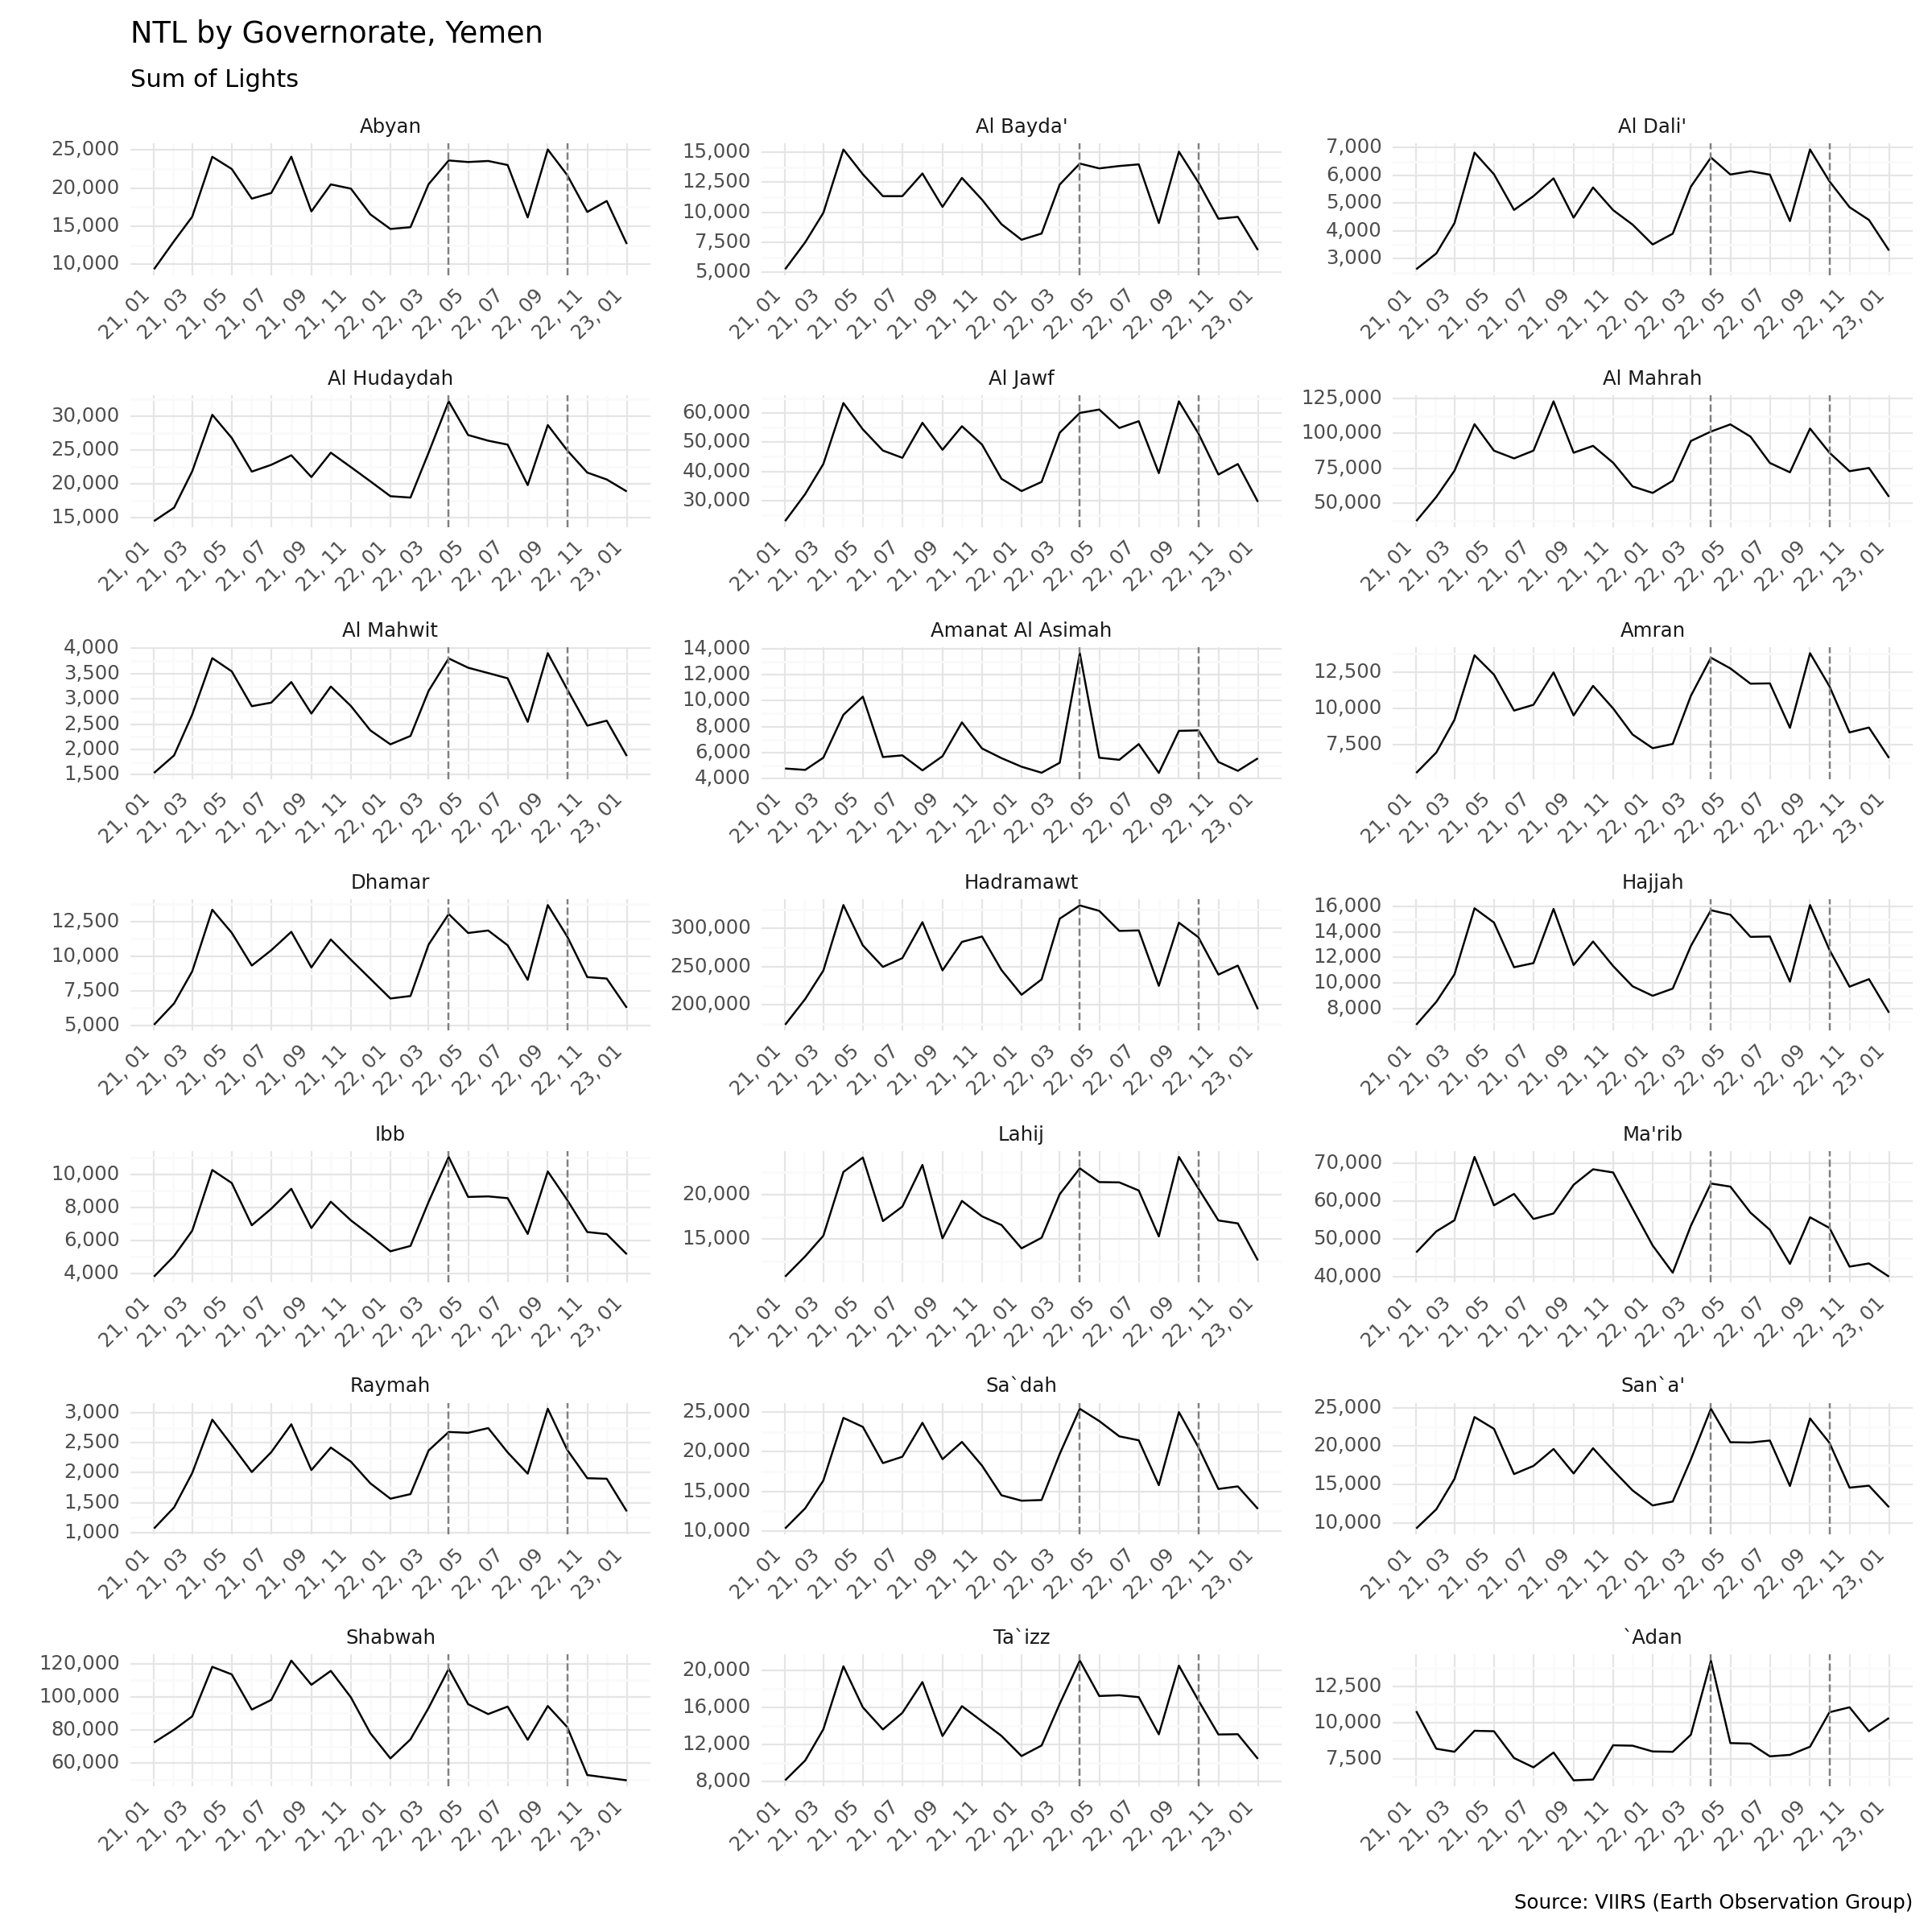

<Figure Size: (1200 x 1200)>

In [27]:
p3 = (
ggplot(df.loc[df.year>=2021], aes(x="ym", y="rad_int", group="NAME_1")) #
    + geom_line(alpha=1)
    # + geom_line(aes(x="ym", y="rad_int_ref", group="NAME_1"), alpha=0.5, color="red")
    # + geom_hline(yintercept=0)
    + geom_vline(xintercept="2022-04-01", linetype="dashed", color = "gray")
    + geom_vline(xintercept="2022-10-01", linetype="dashed", color = "gray")
    + labs(
        x="", y="", title="NTL by Governorate, Yemen", subtitle="Sum of Lights",
        caption="Source: VIIRS (Earth Observation Group)"
    )
    + theme_minimal() 
    + scale_x_datetime(breaks=date_breaks('2 months'), labels=date_format('%y, %m'))
    + scale_y_continuous(labels=comma_format())
    + theme(legend_position='bottom')
    + facet_wrap("~NAME_1", scales = "free", ncol=3)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    # + scale_color_manual(values=['#d73027', '#1a9850'], labels=['True', 'Monthly Reference'])
    # + scale_fill_brewer(type="div", palette="RdYlGn", name="Change in NTL", direction=1)
    # + scale_fill_distiller(type="div", palette="RdYlGn", name="Change in NTL", direction=1, limits=(-1, 1))
)
p3
# p3.save(filename=join(output_dir, 'adm1-lights.jpeg'), dpi=300)

In [52]:
df_historical_baseline.drop(['rad', 'rad_ref'], axis=1, inplace=True)

In [54]:
df_historical_baseline.to_csv(join(output_dir, 'adm1_viirs_pct_change.csv'), index=False)